In [17]:
from typing import Dict
from time import perf_counter_ns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cirq
import openfermion as of
import quimb.tensor as qtn
from adaptvqe.pools import FullPauliPool, TiledPauliPool
from adaptvqe.algorithms.adapt_vqe import TensorNetAdapt, LinAlgAdapt
from adaptvqe.hamiltonians import XXZHamiltonian
from adaptvqe.tensor_helpers import pauli_sum_to_mpo

## DMRG

In [18]:
max_mpo_bond = 100
max_mps_bond = 30
system_sizes = [3, 4, 6]
dmrg_energies: Dict[int, float] = {}

for l in system_sizes:
    j_xy = 1
    j_z = 1
    h = XXZHamiltonian(j_xy, j_z, l)
    qs = cirq.LineQubit.range(l)
    h_cirq = of.transforms.qubit_operator_to_pauli_sum(h.operator)
    h_mpo = pauli_sum_to_mpo(h_cirq, qs, max_mpo_bond)

    dmrg = qtn.DMRG(h_mpo, max_mps_bond)
    converged = dmrg.solve()
    if not converged:
        print("DRMG did not converge.")
    ground_energy = dmrg.energy
    print(f"At size {l} got energy {ground_energy}")
    dmrg_energies[l] = ground_energy

At size 3 got energy (-4.0000000000000036+3.885780586188048e-16j)
At size 4 got energy (-6.464101615137758-8.881784197001252e-16j)
At size 6 got energy (-9.974308535551703+2.4424906541753444e-15j)


## ADAPT-VQE

In [19]:
adapt_energies: Dict[int, float] = {}
adapt_runtimes: Dict[int, float] = {}

for l in system_sizes:
    j_xy = 1
    j_z = 1
    h = XXZHamiltonian(j_xy, j_z, l)
    start_time = perf_counter_ns()
    pool = FullPauliPool(n=l, max_mpo_bond=max_mpo_bond)
    tn_adapt = TensorNetAdapt(
        pool=pool,
        custom_hamiltonian=h,
        verbose=True,
        threshold=10**-5,
        max_adapt_iter=15,
        max_opt_iter=10000,
        sel_criterion="gradient",
        recycle_hessian=False,
        rand_degenerate=True,
        max_mpo_bond=max_mpo_bond,
        max_mps_bond=max_mps_bond
    )
    tn_adapt.run()
    end_time = perf_counter_ns()
    elapsed_time = end_time - start_time
    print(f"For l={l} got energy {tn_adapt.energy} in {elapsed_time:4.5e} ns.")
    adapt_energies[l] = tn_adapt.energy
    adapt_runtimes[l] = elapsed_time


tensor-net-adapt prepared with the following settings:
> Pool: full_pauli_pool
> Custom Hamiltonian: XXZ_1_1
> Orbital Optimization: False
> Selection method: gradient
> Convergence criterion: total_g_norm
> Recycling Hessian: False
> Tetris: False (progressive optimization: False)
> Convergence threshold (gradient norm):  1e-05
> Maximum number of iterations:  15
> candidates per iteration:  1

Initial energy: -2.000000000000001

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 6: 3.9999999999999987
Operator 7: 3.9999999999999987
Operator 18: -3.9999999999999987
Operator 19: -3.9999999999999987
Operator 33: -4.000000000000005
Operator 36: 4.000000000000005
Operator 49: -4.000000000000005
Operator 52: 4.000000000000005
Total gradient norm: 11.313708498984765
Operators under consideration (1):
[36]
Corresponding gradients (ordered by magnitude):
[np.float64(4.000000000000005)]
Operator(s) ad

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Operator 21: 1.4555410277061753e-07
Operator 26: 1.1184079540260683e-07
Operator 27: -2.0000000000000004
Operator 30: 2.0000000000000004
Operator 31: -1.1184079540260683e-07
Operator 38: 3.371330448143084e-08
Operator 39: 2.0000000000000036
Operator 45: -2.0000000000000036
Operator 54: -2.0000000000000036
Operator 55: -3.3713303815297024e-08
Operator 57: 2.0000000000000027
Operator 64: -1.4555410232652832e-07
Operator 69: -1.4555410254857293e-07
Operator 74: -1.1184079562465143e-07
Operator 75: 2.0
Operator 78: -2.0000000000000004
Operator 79: 1.1184079595771834e-07
Operator 81: 6.742661562419983e-08
Operator 84: -6.742661562419983e-08
Operator 98: -3.371330359325242e-08
Operator 99: -2.000000000000003
Operator 108: 2.0000000000000027
Operator 114: 2.0000000000000036
Operator 115: 3.3713304703475444e-08
Operator 120: -2.0000000000000036
Operator 134: -1.0649035320220435e-07
Operator 135: -2.000000000000006
Operator 137: 7.277704650032746e-08
Operator 141: 2.000000000000005
Operator 146

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -9.000000
         Iterations: 10
         Function evaluations: 64
         Gradient evaluations: 52

Current energy: -9.000000000000007
(change of -1.7049644418179035)
Current ansatz: [4084, 3914, 1279]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 1: -3.872042597663494e-08
Operator 4: 3.872042686481336e-08
Operator 16: -3.580749630138769e-08
Operator 21: -3.580749630138769e-08
Operator 26: -1.644728209182489e-08
Operator 27: 2.0000000000000018
Operator 30: -2.0000000000000018
Operator 31: 1.644728209182489e-08
Operator 38: -1.9360216207964243e-08
Operator 39: -2.000000000000002
Operator 45: 2.000000000000002
Operator 54: 2.000000000000001
Operator 55: 1.9360214542629706e-08
Operator 57: -2.000000000000001
Operator 64: 3.580749652343229e-08
Operator 69: 3.580749563525387e-08
Operator 74: 1.6447281425691074e-08
Operator 75: -2.0000000000000013
Operator 7

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -9.123106
         Iterations: 5
         Function evaluations: 34
         Gradient evaluations: 22

Current energy: -9.123105625617665
(change of -0.12310562561765792)
Current ansatz: [4084, 3914, 1279, 4056]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 1: -4.004589882530135e-08
Operator 4: 4.4975773737243596e-08
Operator 16: -6.660914857658726e-08
Operator 21: -6.167927423211643e-08
Operator 26: -4.135287795688485e-08
Operator 27: 1.9402850507068665
Operator 30: -2.4850710484078338
Operator 31: 4.1959770569763646e-08
Operator 38: -2.5256271862523355e-08
Operator 39: -8.570755536030143e-07
Operator 41: 1.4789621790049431e-08
Operator 45: 8.570755535724673e-07
Operator 54: 2.4850710484078333
Operator 55: 1.2126441550561196e-08
Operator 57: -1.9402850507068672
Operator 64: 6.167927423081539e-08
Operator 69: 6.660914901796596e-08
Operator 74: 4.1959771443

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -9.327276
         Iterations: 6
         Function evaluations: 66
         Gradient evaluations: 54

Current energy: -9.327276154820069
(change of -0.20417052920240408)
Current ansatz: [4084, 3914, 1279, 4056, 4020]

*** ADAPT-VQE Iteration 6 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 1: 2.9651467631230943e-07
Operator 4: -3.4285746441931053e-07
Operator 16: 7.52898877687258e-08
Operator 21: 2.8947097829856716e-08
Operator 26: -3.6836236505521924e-08
Operator 27: -0.7090308237828263
Operator 30: -2.6733517046678006e-06
Operator 31: 1.3033647716653718e-08
Operator 38: 2.0740683604410764e-07
Operator 39: 0.7090377214854449
Operator 41: -1.4162378193793845e-07
Operator 45: -6.564963662172234e-06
Operator 54: 2.08949231245003
Operator 55: -9.111622406576814e-08
Operator 57: -2.0894899718372884
Operator 61: -3.622874783504315e-08
Operator 64: -2.8947098162923623e-08
Operator 69: -7.

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -9.592854
         Iterations: 12
         Function evaluations: 92
         Gradient evaluations: 80

Current energy: -9.592854285202835
(change of -0.12875267006511137)
Current ansatz: [4084, 3914, 1279, 4056, 4020, 3996, 3456]

*** ADAPT-VQE Iteration 8 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 1: -9.136148987364846e-08
Operator 4: 1.1953038308437896e-07
Operator 16: -6.888557004718424e-08
Operator 21: -4.0753330747805155e-08
Operator 26: -2.119488393343208e-08
Operator 27: -9.543579832018523e-08
Operator 30: 2.3802240013017587e-07
Operator 31: 2.6357171510442423e-08
Operator 38: -5.703737661084257e-08
Operator 39: -1.4336694975847323e-07
Operator 41: 3.718210897052203e-08
Operator 45: 9.013641427590498e-08
Operator 54: -3.81497880218727e-07
Operator 55: 3.749634941159052e-08
Operator 57: 2.925140224505732e-07
Operator 61: -2.3100191252900526e-08
Operator 64: 4.9818147896448

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -9.812121
         Iterations: 12
         Function evaluations: 52
         Gradient evaluations: 41

Current energy: -9.812121033954261
(change of -0.21926674875142638)
Current ansatz: [4084, 3914, 1279, 4056, 4020, 3996, 3456, 3605]

*** ADAPT-VQE Iteration 9 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 1: 1.1278006706305632e-07
Operator 4: -1.48555516332749e-07
Operator 16: 1.1940114053032858e-07
Operator 21: 8.370914228450488e-08
Operator 26: 6.011270747841024e-08
Operator 27: 0.0001179364564598205
Operator 30: -8.651252414221605e-05
Operator 31: -6.66695396667194e-08
Operator 38: 6.424312504194063e-08
Operator 39: -3.179688626970843e-05
Operator 41: -4.0648128418752094e-08
Operator 45: -3.262611696555939e-05
Operator 54: -8.024947846249937e-05
Operator 55: -3.9488063041659416e-08
Operator 57: 0.00011365734140089185
Operator 61: 2.317994152178926e-08
Operator 64: -1.040782717

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -9.954831
         Iterations: 17
         Function evaluations: 69
         Gradient evaluations: 59

Current energy: -9.954831343189225
(change of -0.14271030923496397)
Current ansatz: [4084, 3914, 1279, 4056, 4020, 3996, 3456, 3605, 3178]

*** ADAPT-VQE Iteration 10 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 1: 3.125732597197839e-07
Operator 4: -4.133010298446038e-07
Operator 16: 2.3532628379285825e-07
Operator 21: 1.3459850611852175e-07
Operator 26: 6.327071777612048e-08
Operator 27: -3.118703000448697e-05
Operator 30: 2.4786912159235897e-05
Operator 31: -8.229910686274877e-08
Operator 38: 1.9695367714511747e-07
Operator 39: 6.9678458338717775e-06
Operator 41: -1.2562481987998808e-07
Operator 45: 8.941860260291978e-06
Operator 54: 1.573220296169353e-05
Operator 55: -1.2946328920016015e-07
Operator 57: -2.524179124130388e-05
Operator 61: 7.716208294539229e-08
Operator 64: -1.

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -9.959455
         Iterations: 16
         Function evaluations: 26
         Gradient evaluations: 26

Current energy: -9.959454845266407
(change of -0.004623502077182096)
Current ansatz: [4084, 3914, 1279, 4056, 4020, 3996, 3456, 3605, 3178, 2387]

*** ADAPT-VQE Iteration 11 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 1: -3.300575102116454e-08
Operator 4: 4.34058149423322e-08
Operator 16: -5.925549118046547e-08
Operator 21: -4.897154148864047e-08
Operator 26: -4.3290385720595737e-08
Operator 27: 1.900383948634554e-05
Operator 30: 0.010381856126169044
Operator 31: 4.522094521064446e-08
Operator 38: -1.3590896630333305e-08
Operator 39: -0.01517824107623755
Operator 45: -5.148563582141046e-06
Operator 54: -1.9649610020365088e-05
Operator 57: 2.431749517344236e-05
Operator 64: 5.700727800928007e-08
Operator 69: 6.596978829875866e-08
Operator 74: 5.506842704061654e-08
Operator 75: 0.

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -9.965154
         Iterations: 13
         Function evaluations: 44
         Gradient evaluations: 43

Current energy: -9.965153983026543
(change of -0.005699137760135642)
Current ansatz: [4084, 3914, 1279, 4056, 4020, 3996, 3456, 3605, 3178, 2387, 3748]

*** ADAPT-VQE Iteration 12 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 27: -3.600703115073277e-05
Operator 30: 0.010020977589314459
Operator 39: -0.01299660601184327
Operator 45: 0.013022986107011907
Operator 54: -0.009956471428539011
Operator 57: -5.4448460284317745e-05
Operator 75: 0.11773075881934263
Operator 78: -0.15751877051495086
Operator 99: -0.045498778965067245
Operator 108: 0.03770739688886876
Operator 114: 0.1618720378530545
Operator 120: -0.10354671573062708
Operator 135: -0.04767610634439119
Operator 141: 0.047697610830301
Operator 147: 0.07182289297963307
Operator 156: -0.08015939827755196
Operator 177: -0.0719038

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -9.969381
         Iterations: 14
         Function evaluations: 41
         Gradient evaluations: 37

Current energy: -9.969380988338362
(change of -0.004227005311818743)
Current ansatz: [4084, 3914, 1279, 4056, 4020, 3996, 3456, 3605, 3178, 2387, 3748, 3496]

*** ADAPT-VQE Iteration 13 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 1: -2.6733272484591453e-08
Operator 4: 3.527396152946949e-08
Operator 16: -8.69729976926692e-08
Operator 21: -7.85227012300993e-08
Operator 26: -7.587973405165371e-08
Operator 27: -0.006802456927376976
Operator 30: 0.013181800148120901
Operator 31: 7.653064004742305e-08
Operator 39: -0.014306225383738963
Operator 45: 0.015068857139930883
Operator 54: -0.004872300686840711
Operator 57: 0.0016938375292834193
Operator 64: 9.104979126206558e-08
Operator 69: 9.705400927373375e-08
Operator 74: 9.041248927310619e-08
Operator 75: 0.12847164049416634
Operator 78

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -9.971767
         Iterations: 20
         Function evaluations: 76
         Gradient evaluations: 67

Current energy: -9.971766770780576
(change of -0.0023857824422144347)
Current ansatz: [4084, 3914, 1279, 4056, 4020, 3996, 3456, 3605, 3178, 2387, 3748, 3496, 2417]

*** ADAPT-VQE Iteration 14 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 1: 1.1860546322850496e-08
Operator 4: -1.563834928219876e-08
Operator 16: 1.271076861542042e-07
Operator 21: 1.2351768052809575e-07
Operator 26: 1.27573106301071e-07
Operator 27: -0.006673121108876953
Operator 30: 0.009567303247839526
Operator 31: -1.2631000134710746e-07
Operator 38: -1.7985422262611905e-08
Operator 39: 0.0017425014492840132
Operator 41: 1.3915877339343297e-08
Operator 45: 0.011192755748230525
Operator 54: -0.008716995677087828
Operator 55: 1.6095232036050788e-08
Operator 57: 0.003665301874871213
Operator 61: -1.2569020491071115e

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -9.973441
         Iterations: 19
         Function evaluations: 57
         Gradient evaluations: 47

Current energy: -9.973441155810221
(change of -0.0016743850296450091)
Current ansatz: [4084, 3914, 1279, 4056, 4020, 3996, 3456, 3605, 3178, 2387, 3748, 3496, 2417, 2857]

*** ADAPT-VQE Iteration 15 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 1: -6.219617487701612e-08
Operator 4: 8.210303548139564e-08
Operator 16: -3.056000452694718e-08
Operator 21: -1.0591399313142347e-08
Operator 27: -0.0032781096014319008
Operator 30: 0.00935875681261113
Operator 38: -4.26577910217496e-08
Operator 39: 0.00271322921656475
Operator 41: 2.6377883655115397e-08
Operator 45: -0.0020610447143016575
Operator 54: -0.005843603442217489
Operator 55: 2.8563692411331942e-08
Operator 57: 0.003676116738189953
Operator 61: -1.626362067241871e-08
Operator 64: 1.4822027605276844e-08
Operator 69: 3.252881430881

In [20]:
records = []
for l in adapt_energies.keys():
    records.append((l, dmrg_energies[l], adapt_energies[l], adapt_runtimes[l]))
df = pd.DataFrame.from_records(records, columns=["l", "dmrg_energies", "adapt_energies", "adapt_runtimes"])
df.set_index("l")
df.to_csv("../data/stress_test_result.csv")

/Users/benjamindalfavero/.venv/adapt/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/benjamindalfavero/.venv/adapt/lib/python3.13/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0, 0.5, 'Energy')

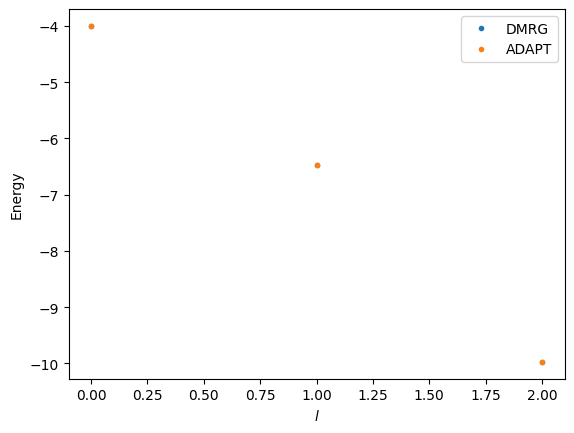

In [21]:
fig, ax = plt.subplots()
ax.plot(df.index, df["dmrg_energies"], '.', label="DMRG")
ax.plot(df.index, df["adapt_energies"], '.', label="ADAPT")
ax.legend()
ax.set_xlabel(r"$l$")
ax.set_ylabel("Energy")

Text(0, 0.5, 'Runtime (ns)')

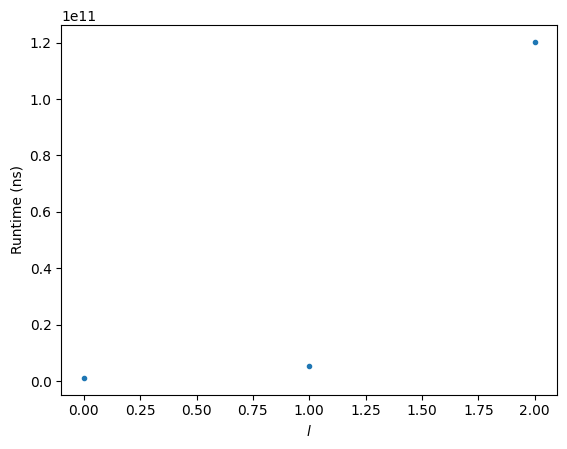

In [22]:
fig2, ax2 = plt.subplots()
ax2.plot(df.index, df["adapt_runtimes"], '.')
ax2.set_xlabel(r"$l$")
ax2.set_ylabel("Runtime (ns)")